In [16]:
#import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as sk
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
from RegscorePy import *
from scalingAnalysis import *
import lmfit
import copy
##### This script is to run testing on different proposed alternative scaling models

# User Configs


In [29]:
years = "2000-2005"

#what features to analyze
#feats = ["GDP","Violent Crime","Total Robberies"]
feats = ["GDP"]#,'Patents''Total Employed'"Unemployment",

# feats to be plotted on a linear regression rather than log-log
linearFeats = []#["Gini Index"]


#includeTag = 'ALL/SEPARATE' # this plots all countries on individual country plots
includeTag = 'ALL/COMBINED' # this plots all countries together
# includeTag = 'ALL/COMBINED+SEPARATE' # this plots each country individually plus all of EU as one (TODO: Not yet implemented)
#includeTag = 'LIST' # this allows manual lists of countries in "countries" above


# what type of connectivity to use for residual plotting    
connectivityTags = {
    #"Connectivity (asymmetric)":1#,
    "Connectivity (symmetric)":1#,
    #"Global Firm Presence (without Connectivity)":1.0
    #"Air Traffic":1
}

# what to call this combination of connectivities in output file
connectivityLbl = "$C_{Symmetric}$"#"Isolated Firm Presence"

# calculate residuals using difference ("diff") or ratio ("ratio") or "SAMI"
resCalc = "SAMI"

# name of external population measure used in borrowed size model testing
#exPop = "Number of Visitors (Estimate by Accommodation GDP)"
exPop = "Air Traffic"

# set true if running on US census data
USData = False

# minimum number of datapoints to plot
dataPlotMin = 7

# what countries to analyze. 
countries = [[#'Australia',
#'Canada',
#'Germany',
#'Spain',
#'France',
#'United Kingdom',
#'Italy',
#'United States (Census)'
]]

# process run parameters and read in Data

In [30]:
if includeTag == 'ALL/SEPARATE':
    countries = []
    #for country in allCountries:
    countries = list(map(lambda x: [x], allCountries))
elif includeTag == 'ALL/COMBINED':
    countries = [allCountries]
elif includeTag == 'LIST':
    countries = countries
elif includeTag == "ALL/COMBINED+SEPARATE":
    countries = list(map(lambda x: [x], allCountries))
    countries = countries + [allCountries]
else:
    print("WHAT COUNTRIES DO YOU WANT?")

# map, mapping countryname to dataframe
data = {}


outDir = "Figures/FullExternalityModeling/"+years

# TODO: Include error bars

# input data file
if USData:
    fIn = "FeaturesUS"+years.replace("-","_")+".xls"
else:
    fIn = "Features"+years.replace("-","_")+".xls"

if USData:
    allCountries = ["United States (Census)"]
    countries = [allCountries]

for country in allCountries:
    data[country] = pd.read_excel(fIn,sheet_name=country)

# Models

In [31]:
def borrowedSizeModelFunc(x,y0,Beta,Alpha):
    return y0*(x['Population']+x[exPop]*Alpha)**Beta

def borrowedSizeModelWithConnsFunc(x,y0,Beta,Alpha):
    return y0*(x['Population']+x[exPop]*x['conn']*Alpha)**Beta

def standardModelFunc(x,y0,delta):
    return y0*(x**(1+delta))


def fullModel(x,y0,delta,deltaPrime,Alpha,y1):
    return y0*(x['Population'])**(1+delta)+y0*x[exPop]*Alpha*(x["Population"])**deltaPrime+y1*x['conn']
def fullModelEqDelta(x,y0,delta,Alpha,y1):
    return y0*(x['Population'])**(1+delta)+y0*x[exPop]*Alpha*(x["Population"])**delta+y1*x['conn']
def visitingModel(x,y0,delta,deltaPrime,Alpha):
    return y0*(x['Population'])**(1+delta)+y0*x[exPop]*Alpha*(x["Population"])**deltaPrime
def visitingModelEqDelta(x,y0,delta,Alpha):
    return y0*(x['Population'])**(1+delta)+y0*x[exPop]*Alpha*(x["Population"])**delta
def institutionalModel(x,y0,delta,y1):
    return y0*(x['Population'])**(1+delta)+y1*x['conn']



def smartLogHelper(x):
    if x < 0:
        return -1*np.log(-1*x)
    elif x < 2:
        return 0
    else:
        return np.log(x)

def smartLog(x):
    
    return np.array(list(map(smartLogHelper,x))) 
    #set_trace()
    #if np.isnan(x):
    #    return 0
    #else:
    #    return logVal



def fullModelLogRes(params,x,data):
    model = fullModel(x,params['y0'],params['delta'],params['deltaPrime'],params['Alpha'],params['y1'])
    if np.nan in smartLog(model) or np.nan in np.log(data):
        set_trace()
    return np.log(data) - smartLog(model)
def fullModelEqDeltaLogRes(params,x,data):
    model = fullModelEqDelta(x,params['y0'],params['delta'],params['Alpha'],params['y1'])
    #if np.nan in smartLog(model) or np.nan in np.log(data):
    #    set_trace()
    return np.log(data) - smartLog(model)
def visitingModelLogRes(params,x,data):
    model = visitingModel(x,params['y0'],params['delta'],params['deltaPrime'],params['Alpha'])
    if np.nan in smartLog(model) or np.nan in np.log(data):
        set_trace()
    return np.log(data) - smartLog(model)
def visitingModelEqDeltaLogRes(params,x,data):
    model = visitingModelEqDelta(x,params['y0'],params['delta'],params['Alpha'])
    if np.nan in smartLog(model) or np.nan in np.log(data):
        set_trace()
    return np.log(data) - smartLog(model)
def institutionalModelLogRes(params,x,data):
    model = institutionalModel(x,params['y0'],params['delta'],params['y1'])
    if np.nan in smartLog(model) or np.nan in np.log(data):
        set_trace()
    return np.log(data) - smartLog(model)
    
    
def borrowLogResidual(params, x, data):
    model = borrowedSizeModelFunc(x,params['y0'],params['Beta'],params['Alpha'])
    return np.log(data)-smartLog(model)
def borrowConnsLogResidual(params, x, data):
    model = borrowedSizeModelWithConnsFunc(x,params['y0'],params['Beta'],params['Alpha'])
    return np.log(data)-smartLog(model)
def standardLogResidual(params, x, data):
    model = standardModelFunc(x,params['y0'],params['delta'])
    return np.log(data)-np.log(model)




# for calculating sum squared residuals of the full test model using the above residual functions
def get_R2_sum(par1,par2,paramfits,data,dataVals):
    # mean of data in log space
    log_data = np.log(dataVals)
    log_mean_data = np.average(log_data)
    log_diff = log_data - log_mean_data
    sum_square_total = np.sum(np.square(log_diff))
    error_cap = 65
    param_vals = paramfits
    all_params = ["y1",'y0','Alpha','delta']
    p1_name = par1[0]
    p2_name = par2[0]
    R2 = np.empty((100,100))
    #TODO: Test if this is producing the correct outputs!
    #i=0
    #for p1_val in par1[1]:
    #    j=0
    #    for p2_val in par2[1]:
    #        param_vals[p1_name] = p1_val
    #        param_vals[p2_name] = p2_val
    #        sum_squared_error = np.sum(np.square(fullModelEqDeltaLogRes(param_vals,data,dataVals)))
    #        #R2_sums[i][j] = min(sum_error,error_cap)
    #        #print("sum_square_total")
    #        #print(str(sum_square_total))
    #        #print("sum_square_error")
    #        #print(str(sum_squared_error))
    #        R2[i][j] = max(0,(1 - sum_squared_error/sum_square_total))
    #        j+=1
    #    i+=1
    for p1_val,i1 in zip(par1[1],range(0,100)):
        for p2_val,i2 in zip(par2[1],range(0,100)):
            param_vals[p1_name] = p1_val
            param_vals[p2_name] = p2_val
            sum_squared_error = np.sum(np.square(fullModelEqDeltaLogRes(param_vals,data,dataVals)))
            #R2_sums[i][j] = min(sum_error,error_cap)
            #print("sum_square_total")
            #print(str(sum_square_total))
            #print("sum_square_error")
            #print(str(sum_squared_error))
            R2[i1][i2] = max(0,(1 - sum_squared_error/sum_square_total))
    return R2    

In [32]:
##data["GDP/Job*Pop"]=data["GDP/Job"]*data["Population"]
#for country in allCountries:
#    data[country]["GDP/Job*Pop"]=data[country]["GDP/Job"]*data[country]["Population"]
#    #data
#feats = ["GDP/Job*Pop"]

In [45]:
# aesthetic parameteres
plt.rc('xtick', labelsize=14)     
plt.rc('ytick', labelsize=14)
plt.rcParams.update({'font.size': 12})

# Run Analysis for Full Externalities 

('Visiting + Institutional', 'GDP', 'All Countries')
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
Alpha    0.2337     -inf      inf  0.05619     True     None     None
delta   0.08122       -1        1  0.05001     True     None     None
y0     0.007574     -inf      inf 0.005657     True     None     None
y1     5.112e+04     -inf      inf 1.424e+04     True     None     None


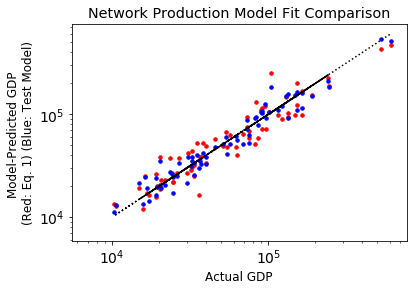

BIC -207.74
AIC -216.79
44.92
40.4


In [46]:
# Borrowed size fitting Analysis
from IPython.core.debugger import set_trace

retParams = {} 

# map tuple(useConns?,feat,country) to Models
standardModels = {}
fullModels = {}
standardFits = {}
fullFits = {}
mini = {}


fitdeltaPrime = False
run_param_uncertainties = False

for modelType in ["Visiting + Institutional"]:# ["Visiting","Institutional","Visiting + Institutional"]:
    
    paramsList = ["n","BIC difference","AIC difference","Avg Local Term","Avg Visiting Term","Avg Institutional Term","Delta (Standard)","Delta (Test Model)"]
    
    if "Visiting" in modelType:
        paramsList += ["Alpha"]
        if fitdeltaPrime:
            paramsList += ["Delta Prime"]
    #if "Institutional" in modelType:
    #    paramsList += ["y1"]
    
    # no connectivity data for US
    if "Institutional" in modelType and USData:
        continue

    # do analysis seperately for every feature
    for feat in feats:
        
        
        countryIndex = list(map(lambda x: x[0], countries)) + ['All Countries']
        retParams[feat] = pd.DataFrame(index=countryIndex, columns=paramsList)
        
        # ignore connectivity vs connectivity
        skip = False
        for connectivityTag in connectivityTags.keys(): 
            if connectivityTag in feat:
                skip = True
                continue
        if skip:
            continue


        for countryList in countries:
            if len(countryList) > 1 and includeTag in "ALL/COMBINED+SEPARATE":
                country = "All Countries"
            elif includeTag in "ALL/COMBINED+SEPARATE" or includeTag == "ALL/SEPARATE":
                country = countryList[0]

            dataToPull = ["Population",feat]
            
            if "Visiting" in modelType:
                dataToPull += [exPop]
            if "Institutional" in modelType:
                dataToPull += [connectivityTag]
            

            plotData = getDataFromList(data,countryList,dataToPull)

            # skip over countryLists without data
            if plotData.empty:
                msg = 'No Data for country {} and feature {}'.format(country,feat)
                #print(msg)
                continue
                
            # skip over countryLists with less than a set number of datapoints
            if len(list(plotData.index)) < dataPlotMin:
                msg = 'Not Enough Data for country {} and feature {}'.format(country,feat)
                #print(msg)
                continue
        
            #print("fitting for R^2 ",str(countryList))
            #print("feat, ",feat)
            
            plotData = plotData.sort_values(by=["Population"])

            
            pop = plotData["Population"]
            featVals = plotData[feat]
            
            
            
            modelTag = (modelType, feat, country)
            print(modelTag)
            standardParams = lmfit.Parameters()
            standardParams.add_many(('y0',list(featVals)[0]/list(pop)[0],True,0,1),('delta',0,True))
            
            fullParams = lmfit.Parameters()
            #fullParams.add_many(('y0',list(featVals)[0]/list(pop)[0],True,0,1),('delta',0,True,-1,1),('Alpha',0,True,alphaMin,1),('y0Prime',list(featVals)[0]/list(pop)[0],True,-1,1),('deltaPrime',0,True,-1,1),('y1',100,True))
            fullParams.add_many(('y0',list(featVals)[0]/list(pop)[0],True),('delta',0,True,-1,1))
            #fullParams.add_many(('y0',list(featVals)[0]/list(pop)[0],True,0,1),('delta',0,True,-1,1))
            
            
            
            
            pop = plotData["Population"]
            featVals = plotData[feat]
            if "Visiting" in modelType:
                aTraffic = plotData[exPop]
                # minimum alpha has to be such that N_i+Alpha*N_e is never zero or below
                alphaMin = -np.min(pop/aTraffic)*0.9
                fullParams.add_many(('Alpha',0,True))
                #fullParams.add_many(('Alpha',0,True,alphaMin,1))
                
                if fitdeltaPrime:
                    fullParams.add_many(('deltaPrime',0,True,-1,1))
                
            if "Institutional" in modelType:
                plotData['conn'] = np.array(plotData[connectivityTag])
                fullParams.add_many(('y1',10000,True))
                
            
            concatData = plotData
                
                
                
            standardModels[modelTag] = lmfit.Model(standardModelFunc)
            standardFits[modelTag] = lmfit.minimize(standardLogResidual, standardParams, args=(pop, featVals))
            
            
            if modelType=="Visiting":
                if fitdeltaPrime:
                    resType = visitingModelLogRes
                    modelFunc = visitingModel
                else:
                    resType = visitingModelEqDeltaLogRes
                    modelFunc = visitingModelEqDelta
            elif modelType=="Institutional":
                resType = institutionalModelLogRes
                modelFunc = institutionalModel
            elif modelType=="Visiting + Institutional":
                if fitdeltaPrime:
                    resType = fullModelLogRes
                    modelFunc = fullModel
                else:
                    resType = fullModelEqDeltaLogRes
                    modelFunc = fullModelEqDelta
                    
            
            #minilbf = lmfit.Minimizer(resType,fullParams,fcn_args=(concatData, featVals))
            ##set_trace()
            #fullFitlbf = minilbf.minimize(method="lbfgsb")#mini.minimize(params=fullParams)
            #fullParamslbf = fullFitlbf.params
            #mininelder = lmfit.Minimizer(resType,fullParams,fcn_args=(concatData, featVals))
            ##set_trace()
            #fullFitnelder = mininelder.minimize(method="nelder")#mini.minimize(params=fullParams)
            #fullParamsnelder = fullFitnelder.params
                

            # TODO: Confidence intervals: https://lmfit.github.io/lmfit-py/confidence.html
            #fullFits[modelTag] = lmfit.minimize(resType, fullParams, args=(concatData, featVals))
            mini[modelTag] = lmfit.Minimizer(resType,fullParams,fcn_args=(concatData, featVals))
            #set_trace()
            fullFits[modelTag] = mini[modelTag].minimize()#mini.minimize(params=fullParams)
            fullModels[modelTag] = lmfit.Model(modelFunc)
            fullParams = fullFits[modelTag].params
            standardParams = standardFits[modelTag].params
            
            #print("ls")
            fullParams.pretty_print()
            #print("lbf")
            #fullParamslbf.pretty_print()
            #print("nelder")
            #fullParamsnelder.pretty_print()
            
            if run_param_uncertainties:

                #TODO: Also run on just institutional or just visiting, compare those variables
                if modelType=="Visiting + Institutional" and country=="All Countries":#"Alpha" in paramsList:

                    par_lims = {}
                    par_lims["Alpha"] = (-3.0*fullParams["Alpha"],fullParams["Alpha"]*4.0)
                    par_lims["delta"] = (-3.0*fullParams["delta"],fullParams["delta"]*4.0)
                    par_lims['y1'] =    (-3.0*fullParams["y1"],fullParams["y1"]*      4.0)
                    par_lims['y0'] =    (-3.0*fullParams["y0"],fullParams["y0"]*      4.0)
                    #par_lims["Alpha"] = (-2*fullParams["Alpha"],fullParams["Alpha"]*16)
                    #par_lims["delta"] = (-2*fullParams["delta"],fullParams["delta"]*16)
                    #par_lims['y1'] =    (-2*fullParams["y1"],fullParams["y1"]*      16)
                    #par_lims['y0'] =    (-2*fullParams["y0"],fullParams["y0"]*      16)
                    # adjust the first param when being compared to the second
                    par_lim_adjustments = {}

                    #par_lim_adjustments[('y0','y1')] = (-4.0*fullParams["y0"],fullParams["y0"]*10.0)
                    par_lim_adjustments[('y1','y0')] = (0.5*fullParams["y1"],fullParams["y1"]*1.5)
                    par_lim_adjustments[('Alpha','y1')] = (-2.0*fullParams["Alpha"],fullParams["Alpha"]*10.0)
                    par_lim_adjustments[('y1','Alpha')] = (-2.0*fullParams["y1"],fullParams["y1"]*10.0)
                    par_lim_adjustments[('delta','y0')] = (-2.0*fullParams["delta"],fullParams["delta"]*10.0)
                    par_lim_adjustments[('y0','delta')] = (-2.0*fullParams["y0"],fullParams["y0"]*10.0)

                    params = ['y1','y0','Alpha','delta']

                    tested_pairs = []

                    #FIXME: Weird results for y0!!

                    for param1 in params:
                        for param2 in params:
                            if not(param1==param2) and not ((param2,param1) in tested_pairs):
                                tested_pairs.append((param1,param2))
                                if (param1,param2) in par_lim_adjustments:
                                    newLims = par_lim_adjustments[(param1,param2)]
                                    par_var1 = np.linspace(newLims[0],newLims[1],100)
                                else:
                                    par_var1 = np.linspace(par_lims[param1][0],par_lims[param1][1],100)
                                if (param2,param1) in par_lim_adjustments:
                                    newLims = par_lim_adjustments[(param2,param1)]
                                    par_var2 = np.linspace(newLims[0],newLims[1],100)
                                else:
                                    par_var2 = np.linspace(par_lims[param2][0],par_lims[param2][1],100)


                                errorsum = get_R2_sum((param1,par_var1),(param2,par_var2),copy.copy(fullParams.valuesdict()),concatData,featVals)

                                fig, ax = plt.subplots()
                                plt.xlabel(param1)
                                plt.ylabel(param2)
                                ttl = feat + " - All Countries"
                                plt.title(ttl) 
                                CS = ax.contourf(par_var1, par_var2, errorsum,cmap="plasma",levels=100) #contour?
                                #ax.clabel(CS, inline=1, fontsize=10)
                                fig.colorbar(CS, ax=ax)
                                ax.plot(np.full(100,fullParams[param1]),par_var2,'g:')
                                ax.plot(par_var1,np.full(100,fullParams[param2]),'g:')
                                plt.show()
                                
                                outname = outDir + "/" + feat + "_" + modelType + "_"+param1+"_"+param2+".png"
                                #plt.savefig(outname)

                #ci = lmfit.conf_interval(mini, fullFits[modelTag],p_names=['delta',"Alpha",'y1'],maxiter=350)
                #lmfit.printfuncs.report_ci(ci)
                #x,y,gr = lmfit.conf_interval2d(mini,fullFits[modelTag],'Alpha','delta')
                ##plt.contour(x,y,gr)
                #fig, ax = plt.subplots()
                #plt.xlabel('Alpha')
                #plt.ylabel('delta')
                #ttl = feat + " - All Countries"
                #plt.title(ttl) 
                #CS = ax.contour(x, y, gr)
                #ax.clabel(CS, inline=1, fontsize=10)
                ##plt.show()
                #outname = outDir + "/" + feat + "_" + modelType + "_alpha_delta.png"
                #plt.savefig(outname)
#
                #x,y,gr = lmfit.conf_interval2d(mini,fullFits[modelTag],'Alpha','y1')
                ##plt.contour(x,y,gr)
                #fig, ax = plt.subplots()
                #plt.xlabel('Alpha')
                #plt.ylabel('y1')
                #ttl = feat + " - All Countries"
                #plt.title(ttl)
                #CS = ax.contour(x, y, gr)
                #ax.clabel(CS, inline=1, fontsize=10)
                ##plt.show()
                #outname = outDir + "/" + feat + "_" + modelType + "_alpha_y1.png"
                #plt.savefig(outname)
#
                #x,y,gr = lmfit.conf_interval2d(mini,fullFits[modelTag],'y1','delta')
                ##plt.contour(x,y,gr)
                #fig, ax = plt.subplots()
                #plt.xlabel('y1')
                #plt.ylabel('delta')
                #ttl = feat + " - All Countries"
                #plt.title(ttl)
                #CS = ax.contour(x, y, gr)
                #ax.clabel(CS, inline=1, fontsize=10)
                ##plt.show()
                #outname = outDir + "/" + feat + "_" + modelType + "_y1_delta.png"
                #plt.savefig(outname)
                    
                    
            #elif modelType=="Visiting" and country=="All Countries":#"Alpha" in paramsList:
            #    ci = lmfit.conf_interval(mini, fullFits[modelTag],p_names=['delta',"Alpha"],maxiter=350)
            #    lmfit.printfuncs.report_ci(ci)
            #    x,y,gr = lmfit.conf_interval2d(mini,fullFits[modelTag],'delta','Alpha')
            #    #plt.contour(x,y,gr)
            #    fig, ax = plt.subplots()
            #    plt.xlabel('delta')
            #    plt.ylabel('Alpha')
            #    ttl = feat + " - All Countries"
            #    plt.title(ttl)
            #    CS = ax.contour(x, y, gr)
            #    ax.clabel(CS, inline=1, fontsize=10)
            #    #plt.show()
            #    outname = outDir + "/" + feat + "_" + modelType + "_delta_alpha.png"
            #    plt.savefig(outname)
            #elif modelType=="Institutional" and country=="All Countries":#"Alpha" in paramsList:
            #    ci = lmfit.conf_interval(mini, fullFits[modelTag],p_names=['delta',"y1"],maxiter=350)
            #    lmfit.printfuncs.report_ci(ci)
            #    x,y,gr = lmfit.conf_interval2d(mini,fullFits[modelTag],'y1','delta')
            #    #plt.contour(x,y,gr)
            #    fig, ax = plt.subplots()
            #    plt.xlabel('y1')
            #    plt.ylabel('delta')
            #    ttl = feat + " - All Countries"
            #    plt.title(ttl)
            #    CS = ax.contour(x, y, gr)
            #    ax.clabel(CS, inline=1, fontsize=10)
            #    #plt.show()
            #    outname = outDir + "/" + feat + "_" + modelType + "_y1_delta.png"
            #    plt.savefig(outname)
                    
            
            plotFull = fullModels[modelTag].eval(fullParams,x=plotData)
            plotStandard = standardModels[modelTag].eval(standardParams,x=pop)
            
    
    
                
    
    
    
            
            #if includeTag == 'ALL/COMBINED':
            #    countryListName = "All Countries"
            #else:
            #    for country in countryList:
            #        app = country + "-"
            #        countryListName = countryListName + (app)
                    
            if USData:
                countryListName = "USA"
            
            outName = outDir + "/" + country+"_"+feat+ "_"+modelType+".png"
            
            #outName = outDir + "/AllCountries_" + feat+ "_Connectivity"
            # TODO: Put Alphas on plots
            # TODO: Label lines
            plt.figure(outName)
            
            plt.loglog(pop,featVals, 'ro')
            x_space = pop# np.linspace(np.min(pop),np.max(pop),len(pop))
            plt.loglog(x_space, plotFull, ':k')
            plt.loglog(x_space, plotStandard, '-b')
            xLbl = "Population"
            yLbl = feat
            plt.xlabel(xLbl)
            plt.ylabel(yLbl)
            ttl = "Scaling vs. "+modelType +" Externalities Model"
            plt.title(ttl)
            #plt.show()

            #plt.savefig(outName)
            plt.close()





            outName = outDir + "/" + country+"_"+feat+ "_"+modelType+"_ModelComparison.png"

            # TODO: Label lines
            plt.figure(outName)
            
            ax = plt.gca()
            
            ax.scatter(featVals,plotStandard, c='r',s=12)
            ax.scatter(featVals,plotFull,  c='b',s=12)
            
            
            ax.set_yscale("log")
            ax.set_xscale("log")
            
            ax.plot(featVals,featVals,    ':k')
            
        
            xLbl = "Actual GDP"
            yLbl = "Model-Predicted GDP \n(Red: Eq. 1) (Blue: Test Model)"
            plt.xlabel(xLbl)
            plt.ylabel(yLbl)
#             ttl = feat+ " - "+country + " - "+modelType
            ttl = "Network Production Model Fit Comparison"
            plt.title(ttl)
            plt.show()
            #plt.savefig(outName)
            plt.close()


            #print(str(modelTag))
            #fullParams.pretty_print()
            


            aicNoBorrowed = round(standardFits[modelTag].aic,2)
            aicWithBorrowed = round(fullFits[modelTag].aic,2)
            bicNoBorrowed =   round(standardFits[modelTag].bic,2)
            bicWithBorrowed = round(fullFits[modelTag].bic,2)
            print("BIC",bicWithBorrowed)
            print("AIC",aicWithBorrowed)
                
            alphaName = "Alpha"
            newaicName = "AIC difference"
            newbicName = "BIC difference"
            newDeltaName = "Delta (Test Model)"

            standardBetaName = "Delta (Standard)"
            
            if "Alpha" in paramsList:
                retParams[feat][alphaName][country] = round(1/fullParams["Alpha"].value)
            #if "y1" in paramsList:
            #    retParams[feat]["y1"][country] = round(fullParams["y1"].value,2)
            if "Delta Prime" in paramsList:
                retParams[feat]["Delta Prime"][country] = round(fullParams["deltaPrime"].value,2)
                
                
            internalTerms = fullParams['y0']*plotData["Population"]**(1+fullParams['delta'])
            internalRatio = np.average(internalTerms/plotFull)
            
            if "Visiting" in modelType:
                visitingTerms = fullParams['y0']*plotData[exPop]*fullParams['Alpha']*plotData["Population"]**fullParams['delta']
                visitingRatio = np.average(visitingTerms/plotFull)
                retParams[feat]["Avg Visiting Term"][country]=round(visitingRatio,2)
                
            if "Institutional" in modelType:
                institutionalTerms = fullParams['y1']*plotData['conn']
                institutionalRatio = np.average(institutionalTerms/plotFull)
                retParams[feat]["Avg Institutional Term"][country]=round(institutionalRatio,2)
                
            retParams[feat]["Avg Local Term"][country]= round(internalRatio,2)
            retParams[feat][newaicName][country] = round((aicNoBorrowed-aicWithBorrowed),2)
            print(round((aicNoBorrowed-aicWithBorrowed),2))
            print(round((bicNoBorrowed-bicWithBorrowed),2))
            retParams[feat][newbicName][country] = round((bicNoBorrowed-bicWithBorrowed),2)
            retParams[feat][newDeltaName][country] = round(fullParams["delta"].value,2)

            retParams[feat][standardBetaName][country] = round(standardParams["delta"].value,2)
            
            retParams[feat]["n"][country] = len(pop)
        
        outName = outDir + "fitParams_"+feat+"_"+modelType+"_"+years+".csv"

#         retParams[feat].dropna(how='all').to_csv(outName)

        
#print(str(retParams))
#with pd.ExcelWriter("Figures/FullExternalityModeling/fitParameters.xls") as writer:
#    for feat in feats:
#        if feat in retParams.keys():
#            retParams[feat].dropna(how='all').to_excel(writer,sheet_name=feat)


# Run Analysis for Borrowed Size
                            

country: All Countries
feat: GDP
unweighted


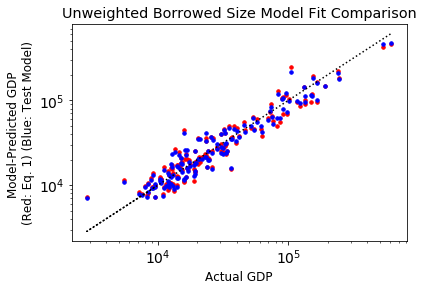

country: All Countries
feat: GDP
weighted


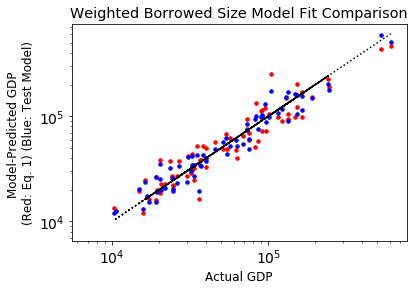

In [49]:
# Borrowed size fitting Analysis
from IPython.core.debugger import set_trace


def standardModelFunc(x,y0,Beta):
    return y0*(x**Beta)

def standardLogResidual(params, x, data):
    model = standardModelFunc(x,params['y0'],params['Beta'])
    return np.log(data)-smartLog(model)


retParams = {} 

# map tuple(useConns?,feat,country) to Models
standardModels = {}
borrowedSizeModels = {}
standardFits = {}
borrowedSizeFits = {}

outDir = "Figures/BorrowedSizeModeling"

for useConns in [False,True]:
    
    
    if useConns:
        paramsList = ["n","Beta (Standard)","Beta (Weighted Borrowed Size)","Alpha","BIC difference","AIC difference"]
    else:
        paramsList = ["n","Beta (Standard)","Beta (Borrowed Size)","Alpha","BIC difference","AIC difference"]
    
    useConnsInBorrow = useConns
    
    # no connectivity data for US
    if useConnsInBorrow and USData:
        continue

    # do analysis seperately for every feature
    for feat in feats:
        
        
        countryIndex = list(map(lambda x: x[0], countries)) + ['All Countries']
        retParams[feat] = pd.DataFrame(index=countryIndex, columns=paramsList)

        # ignore connectivity vs connectivity
        skip = False
        for connectivityTag in connectivityTags.keys(): 
            if connectivityTag in feat:
                skip = True
                continue
        if skip:
            continue



        for countryList in countries:
            
            

            if len(countryList) > 1 and includeTag in "ALL/COMBINED+SEPARATE":
                country = "All Countries"
            elif includeTag in "ALL/COMBINED+SEPARATE" or includeTag == "ALL/SEPARATE":
                country = countryList[0]
            
            
            dataToPull = ["Population",feat,exPop]
            if useConnsInBorrow:
                dataToPull = dataToPull + list(connectivityTags.keys())
                
                
            print("country:",country)
            print("feat:",feat)
            if useConns:
                print("weighted")
            else:
                print("unweighted")
            

            plotData = getDataFromList(data,countryList,dataToPull)

            # skip over countryLists without data
            if plotData.empty:
                msg = 'No Data for country {} and feature {}'.format(country,feat)
                #print(msg)
                continue
                
            # skip over countryLists with less than a set number of datapoints
            if len(list(plotData.index)) < dataPlotMin:
                msg = 'Not Enough Data for country {} and feature {}'.format(country,feat)
                #print(msg)
                continue
        
            #print("fitting for R^2 ",str(countryList))
            #print("feat, ",feat)
            
            plotData = plotData.sort_values(by=["Population"])

            pop = plotData["Population"]
            featVals = plotData[feat]
            aTraffic = plotData[exPop]
            if useConnsInBorrow:
                #conns = getNetConnectivities(connectivityTags,plotData)
                plotData['conn'] = np.array(plotData[connectivityTag]) +np.ones(len(pop))
                
            
            concatData = plotData
                
                
            # minimum alpha has to be such that N_i+Alpha*N_e is never zero or below
            alphaMin = -np.min(pop/aTraffic)*0.9
                
            modelTag = (useConnsInBorrow,feat, country)
            standardParams = lmfit.Parameters()
            standardParams.add_many(('y0',list(featVals)[0]/list(pop)[0],True,0,1),('Beta',1,True))
            
            borrowedParams = lmfit.Parameters()
            borrowedParams.add_many(('y0',list(featVals)[0]/list(pop)[0],True,0,1),('Beta',1,True),('Alpha',0,True,alphaMin,1))
            
            standardModels[modelTag] = lmfit.Model(standardModelFunc)
            standardFits[modelTag] = lmfit.minimize(standardLogResidual, standardParams, args=(pop, featVals))
            

            # TODO: Confidence intervals: https://lmfit.github.io/lmfit-py/confidence.html
            if useConnsInBorrow:
                borrowedSizeFits[modelTag] = lmfit.minimize(borrowConnsLogResidual, borrowedParams, args=(concatData, featVals))
                borrowedSizeModels[modelTag] = lmfit.Model(borrowedSizeModelWithConnsFunc)
            else:
                borrowedSizeFits[modelTag] = lmfit.minimize(borrowLogResidual, borrowedParams, args=(concatData, featVals))
                borrowedSizeModels[modelTag] = lmfit.Model(borrowedSizeModelFunc)
                
            borrowedParams = borrowedSizeFits[modelTag].params
            standardParams = standardFits[modelTag].params
            
            
            plotBorrow = borrowedSizeModels[modelTag].eval(borrowedParams,x=plotData)
            plotStandard = standardModels[modelTag].eval(standardParams,x=pop)
            
    
            

            outDir = "Figures/BorrowedSizeModeling/"+years
            countryListName = country
            #if includeTag == 'ALL/COMBINED':
            #    countryListName = "AllCountriess"
            #else:
            #    for country in countryList:
            #        app = country + "-"
            #        countryListName = countryListName + (app)
                    
            if USData:
                countryListName = "USA "
            
            if useConnsInBorrow:
                outName = outDir + "/" + countryListName+"_"+feat+ "_WithConns.png"
            else:
                outName = outDir + "/" + countryListName+"_"+feat+ ".png"
            #outName = outDir + "/AllCountries_" + feat+ "_Connectivity"
            # TODO: Put Alphas on plots
            # TODO: Label lines
#             plt.figure(outName)
            
#             plt.loglog(pop,featVals, 'ro')
#             x_space = pop# np.linspace(np.min(pop),np.max(pop),len(pop))
#             plt.loglog(x_space, plotBorrow, ':k')
#             plt.loglog(x_space, plotStandard, '-b')
#             xLbl = "Population"
#             yLbl = feat
#             plt.xlabel(xLbl)
#             plt.ylabel(yLbl)
#             ttl = "Scaling with Borrowed Size Model"
#             plt.title(ttl)
#             plt.show()

#             #plt.savefig(outName)
#             plt.close()






            if useConnsInBorrow:
                outName = outDir + "/" + countryListName+"_"+feat+ "_ModelComparisonWithConns"+ ".png"
            else:
                outName = outDir + "/" + countryListName+"_"+feat+ "_ModelComparison"+ ".png"
            # TODO: Label lines
            plt.figure(outName)
            
            ax = plt.gca()
            
            ax.scatter(featVals,plotStandard, c='r',s=12)
            ax.scatter(featVals,plotBorrow,  c='b',s=12)
            
            
            ax.set_yscale("log")
            ax.set_xscale("log")
            
            ax.plot(featVals,featVals,    ':k')
            
        
            xLbl = "Actual GDP"
            yLbl = "Model-Predicted GDP \n(Red: Eq. 1) (Blue: Test Model)"
            plt.xlabel(xLbl)
            plt.ylabel(yLbl)
#             ttl = feat+ " - "+country + " - "+modelType
            if useConns:
                ttl = "Weighted Borrowed Size Model Fit Comparison"
            else:
                ttl = "Unweighted Borrowed Size Model Fit Comparison"
            plt.title(ttl)
            plt.show()
            #plt.savefig(outName)
            plt.close()




            aicNoBorrowed = round(standardFits[modelTag].aic,2)
            aicWithBorrowed = round(borrowedSizeFits[modelTag].aic,2)
            bicNoBorrowed =   round(standardFits[modelTag].bic,2)
            bicWithBorrowed = round(borrowedSizeFits[modelTag].bic,2)



            if useConnsInBorrow:
                withConnData = "With"
                connTag = "Weighted "
            else:
                connTag = ""
                withConnData = "Without"
                
            alphaName = "Alpha"
            newaicName = "AIC difference"
            newbicName = "BIC difference"
            newBetaName = "Beta ("+connTag+"Borrowed Size)"

            standardBetaName = "Beta (Standard)"

            retParams[feat][alphaName][country] = round(1/borrowedParams["Alpha"])
            retParams[feat][newaicName][country] = round((aicNoBorrowed-aicWithBorrowed),2)
            retParams[feat][newbicName][country] = round((bicNoBorrowed-bicWithBorrowed),2)
            retParams[feat][newBetaName][country] = round(borrowedParams["Beta"].value,2)

            retParams[feat][standardBetaName][country] = round(standardParams["Beta"].value,2)
            
            retParams[feat]["n"][country] = len(pop)
            

        outName = outDir + "fitParams_"+feat+"_"+connTag+"_"+years+".csv"

        retParams[feat].dropna(how='all').to_csv(outName)
            
            

        
#print(str(retParams))
#with pd.ExcelWriter("Figures/BorrowedSizeModeling/fitParameters.xls") as writer:
#    for feat in feats:
#        if feat in retParams.keys():
#            retParams[feat].dropna(how='all').to_excel(writer,sheet_name=feat)
